In [2]:
pip install transformers datasets torch seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.6 MB/s eta 0:

# Data preprocessing

**Importing annotated dataset from huggingface, that i have found** 

In [40]:
import pandas as pd
from datasets import Dataset

df = pd.read_parquet("hf://datasets/LocalDoc/azerbaijani-ner-dataset/data/train-00000-of-00001.parquet")
df = df[:10000]
dataset = Dataset.from_pandas(df)


**Defining label mappings**

In [41]:

label_list = [
    "O", "B-PERSON", "B-LOCATION", "B-ORGANISATION", "B-DATE", 
    "B-TIME", "B-MONEY", "B-PERCENTAGE", "B-FACILITY", "B-PRODUCT",
    "B-EVENT", "B-ART", "B-LAW", "B-LANGUAGE", "B-GPE",
    "B-NORP", "B-ORDINAL", "B-CARDINAL", "B-DISEASE", "B-CONTACT",
    "B-ADAGE", "B-QUANTITY", "B-MISCELLANEOUS", "B-POSITION", "B-PROJECT"
]

# Add I- versions
label_list += [f"I-{label[2:]}" for label in label_list[1:]]
num_labels = len(label_list)

# Create mapping dictionaries
id2label = {i: label for i, label in enumerate(label_list)}
label2id = {label: i for i, label in enumerate(label_list)}

**Tags in the dataset are strings, so we covert them into integers via following function**

In [42]:
import ast 
def convert_and_validate(example):
    try:
        # Convert string representations to lists
        if isinstance(example["tokens"], str):
            example["tokens"] = ast.literal_eval(example["tokens"])
        if isinstance(example["ner_tags"], str):
            example["ner_tags"] = ast.literal_eval(example["ner_tags"])
        
        # Ensure tags are integers and validate lengths
        example["ner_tags"] = [int(tag) for tag in example["ner_tags"]]
        if len(example["ner_tags"]) != len(example["tokens"]):
            example["ner_tags"] = [0] * len(example["tokens"])
            
    except Exception as e:
        print(f"Error processing example: {e}")
        example["tokens"] = []
        example["ner_tags"] = []
    
    return example


try:
    dataset = dataset.map(convert_and_validate)
except Exception as e:
    print(f"Mapping failed: {e}")
    # Fallback to empty dataset if conversion fails completely
    dataset = DatasetDict({
        "train": Dataset.from_dict({"tokens": [], "ner_tags": []}),
        "test": Dataset.from_dict({"tokens": [], "ner_tags": []})
    })

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [43]:
from transformers import AutoTokenizer

# Split into train and test (80/20)
train_test_split = dataset.train_test_split(test_size=0.2, seed=42)

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")


In [44]:
train_test_split['train'][0]

{'index': '4c4ab814-a214-4b5d-b1f1-3773f889d266',
 'tokens': ['Və',
  'Azərbaycana',
  'qayıtdıqdan',
  'sonra',
  'THY',
  '-',
  'nı',
  'məhkəməyə',
  'verib',
  '.'],
 'ner_tags': [0, 14, 0, 0, 3, 0, 0, 0, 0, 0]}

**Tokenization and label alignment**

In [45]:

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        padding="max_length",
        max_length=128,
        return_offsets_mapping=True
    )
    
    labels = []
    for i, label_ids in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids_new = []
        
        for word_idx in word_ids:
            # Special tokens get -100
            if word_idx is None:
                label_ids_new.append(-100)
            # New word starts
            elif word_idx != previous_word_idx:
                label_ids_new.append(label_ids[word_idx])
            # Continuation of same word
            else:
                # Convert B- to I- for continuation
                original_tag = label_list[label_ids[word_idx]]
                if original_tag.startswith("B-"):
                    continuation_tag = f"I-{original_tag[2:]}"
                    label_ids_new.append(label2id[continuation_tag])
                else:
                    label_ids_new.append(label_ids[word_idx])
            previous_word_idx = word_idx
        
        labels.append(label_ids_new)
    
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# 7. Apply tokenization
tokenized_datasets = train_test_split.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=train_test_split["train"].column_names
)


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

**Rechecking tags to reassure readiness of the dataset**

In [46]:
def analyze_tags(split_name, dataset):
    all_tags = [tag for sublist in dataset[split_name]["labels"] for tag in sublist if tag != -100]
    tag_counts = Counter([id2label[tag] for tag in all_tags])
    print(f"\n{split_name} tag distribution:")
    for tag, count in tag_counts.most_common():
        print(f"{tag}: {count}")

analyze_tags("train", tokenized_datasets)
analyze_tags("test", tokenized_datasets)


train tag distribution:
O: 242066
I-ORGANISATION: 11712
I-PERSON: 9843
B-ORGANISATION: 6344
B-PERSON: 5067
I-MISCELLANEOUS: 4515
B-GPE: 3630
I-GPE: 3360
B-MISCELLANEOUS: 2699
I-LOCATION: 2665
B-DATE: 2243
I-DATE: 2174
I-FACILITY: 2077
B-CARDINAL: 1805
B-LOCATION: 1484
I-POSITION: 1385
I-PRODUCT: 1351
I-EVENT: 1227
B-FACILITY: 1048
I-NORP: 901
B-PRODUCT: 793
B-POSITION: 765
B-EVENT: 684
B-NORP: 480
B-ORDINAL: 424
I-ART: 412
I-CARDINAL: 407
I-DISEASE: 405
I-PROJECT: 347
I-MONEY: 337
B-ART: 314
B-MONEY: 311
I-TIME: 290
B-QUANTITY: 274
I-ORDINAL: 267
B-TIME: 227
I-QUANTITY: 204
B-DISEASE: 170
B-PROJECT: 166
I-LAW: 158
B-PERCENTAGE: 107
I-PERCENTAGE: 101
B-LAW: 72
B-LANGUAGE: 46
I-CONTACT: 38
I-ADAGE: 34
I-LANGUAGE: 25
B-CONTACT: 22
B-ADAGE: 16

test tag distribution:
O: 62268
I-ORGANISATION: 2790
I-PERSON: 2707
B-ORGANISATION: 1565
B-PERSON: 1435
I-MISCELLANEOUS: 1166
B-GPE: 1000
I-GPE: 945
B-MISCELLANEOUS: 726
B-DATE: 605
I-DATE: 594
I-LOCATION: 583
I-FACILITY: 560
B-CARDINAL: 450
I-PROD

# Training

**Initializing the model for training**

In [47]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
import torch
from sklearn.metrics import classification_report
import numpy as np
# 1. Initialize the model
model = AutoModelForTokenClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
import torch
print(f"GPU available: {torch.cuda.is_available()}")
print(f"GPU name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

GPU available: True
GPU name: Tesla T4


**Function to be used for model evaluation**

In [49]:
from sklearn.metrics import precision_score, recall_score, f1_score
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Removing ignored index (special tokens)
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2label[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    # Flattenning the lists
    flat_predictions = [item for sublist in true_predictions for item in sublist]
    flat_labels = [item for sublist in true_labels for item in sublist]

    return {
        "precision": precision_score(flat_labels, flat_predictions, average="micro", zero_division=0),
        "recall": recall_score(flat_labels, flat_predictions, average="micro", zero_division=0),
        "f1": f1_score(flat_labels, flat_predictions, average="micro", zero_division=0),
    }

In [50]:
import torch
from transformers import Trainer, TrainingArguments
from accelerate import Accelerator

# Clearing all CUDA cache and reset state
torch.cuda.empty_cache()
Accelerator().free_memory()  # Reset accelerator state


training_args = TrainingArguments(
    output_dir="./ner_model_gpu",
    eval_strategy="epoch", 
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    fp16=True,  # Enable mixed precision
    logging_dir='./logs',
    save_strategy="epoch",
    report_to="none",
    gradient_accumulation_steps=1,
    learning_rate=3e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1"
)

In [51]:
#  Creating trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

/tmp/ipykernel_36/2997124894.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [52]:

# Initialize accelerator
accelerator = Accelerator()
trainer.accelerator = accelerator
trainer._accelerator = accelerator
trainer.state._accelerator = accelerator

# Training 
trainer.train()

# Start training with proper cleanup
try:
    print("Starting GPU training...")
    trainer.train()
except Exception as e:
    print(f"Training failed: {e}")
    torch.cuda.empty_cache()
    raise
finally:
    torch.cuda.empty_cache()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.442316,0.872477,0.872477,0.872477
2,0.549700,0.429959,0.863931,0.863931,0.863931
3,0.549700,0.398387,0.872771,0.872771,0.872771
4,0.311300,0.413284,0.877376,0.877376,0.877376
5,0.311300,0.429933,0.868499,0.868499,0.868499
6,0.210100,0.470341,0.865932,0.865932,0.865932
7,0.210100,0.489483,0.869960,0.869960,0.869960
8,0.148200,0.531492,0.866927,0.866927,0.866927
9,0.148200,0.546099,0.868474,0.868474,0.868474
10,0.114400,0.552624,0.869076,0.869076,0.869076


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

RuntimeError: [enforce fail at inline_container.cc:626] . unexpected pos 683459776 vs 683459664

# Visualization and Analysis of training results

Token-level Classification Report:
                 precision    recall  f1-score   support

      B-PROJECT       0.56      0.34      0.42        44
        I-EVENT       0.51      0.53      0.52       336
          I-LAW       0.22      0.43      0.29        37
      I-CONTACT       0.00      0.00      0.00        10
         I-NORP       0.82      0.92      0.87       214
      B-DISEASE       0.37      0.45      0.40        40
     I-QUANTITY       0.49      0.51      0.50        41
          I-GPE       0.70      0.75      0.72       945
   I-PERCENTAGE       0.50      0.60      0.55        30
 I-ORGANISATION       0.69      0.76      0.72      2790
         I-DATE       0.73      0.75      0.74       594
          I-ART       0.51      0.57      0.54       127
     B-QUANTITY       0.61      0.74      0.67        62
       B-PERSON       0.88      0.87      0.87      1435
         I-TIME       0.69      0.83      0.76        60
      B-PRODUCT       0.50      0.39      0.44      

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


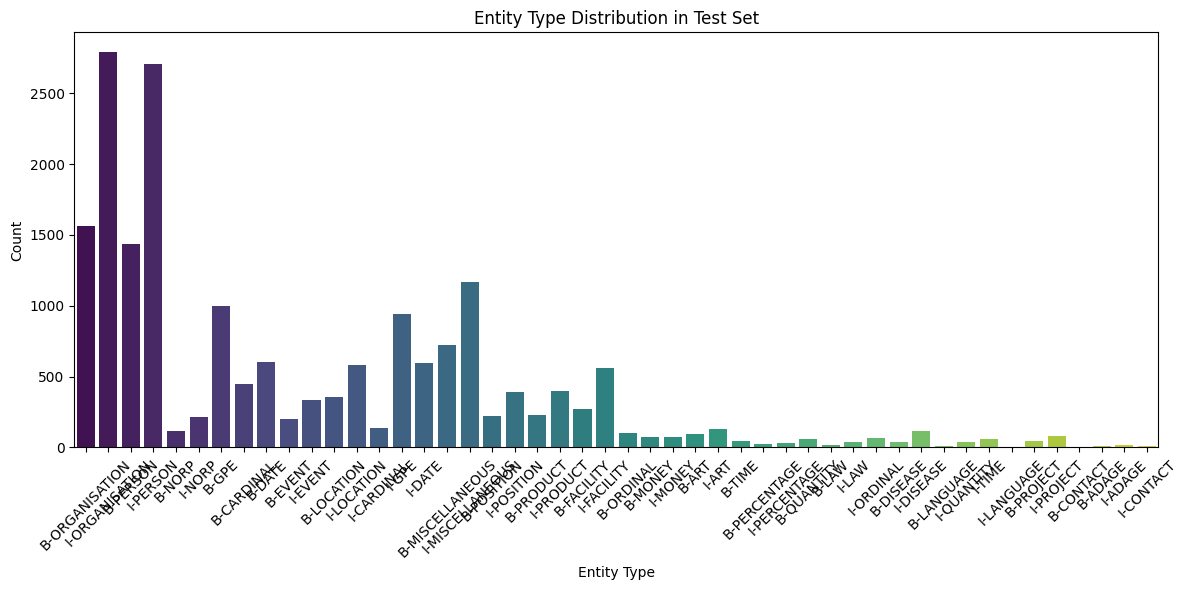

KeyError: "['accuracy'] not found in axis"

In [60]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from seqeval.metrics import classification_report as seqeval_classification_report

# Get all unique labels (excluding 'O')
unique_labels = list(set(id2label.values()) - {"O"})

# Generate token-level report
print("Token-level Classification Report:")
print(classification_report(
    sum(true_labels, []),
    sum(true_predictions, []),
    labels=unique_labels,  # Explicitly specify labels
    target_names=unique_labels,
    zero_division=0
))

# Generate entity-level report
print("\nEntity-level Classification Report:")
print(seqeval_classification_report(true_labels, true_predictions, zero_division=0))

# Count entities in test set
entity_counts = Counter([tag for sublist in true_labels for tag in sublist if tag != "O"])

# Visualization 1: Entity Distribution
plt.figure(figsize=(12, 6))
sns.barplot(
    x=list(entity_counts.keys()),
    y=list(entity_counts.values()),
    palette="viridis"
)
plt.title("Entity Type Distribution in Test Set")
plt.xlabel("Entity Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualization 2: Performance Metrics
report = classification_report(
    sum(true_labels, []),
    sum(true_predictions, []),
    labels=unique_labels,
    target_names=unique_labels,
    output_dict=True,
    zero_division=0
)

# Convert to DataFrame for easier plotting
metrics_df = pd.DataFrame(report).transpose().drop(['accuracy', 'macro avg', 'weighted avg'])
metrics_df = metrics_df[metrics_df.index != 'O']  # Exclude 'O' class

plt.figure(figsize=(15, 8))
metrics_df[['precision', 'recall', 'f1-score']].plot(kind='bar', color=['#3498db', '#2ecc71', '#e74c3c'])
plt.title("NER Performance by Entity Type")
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

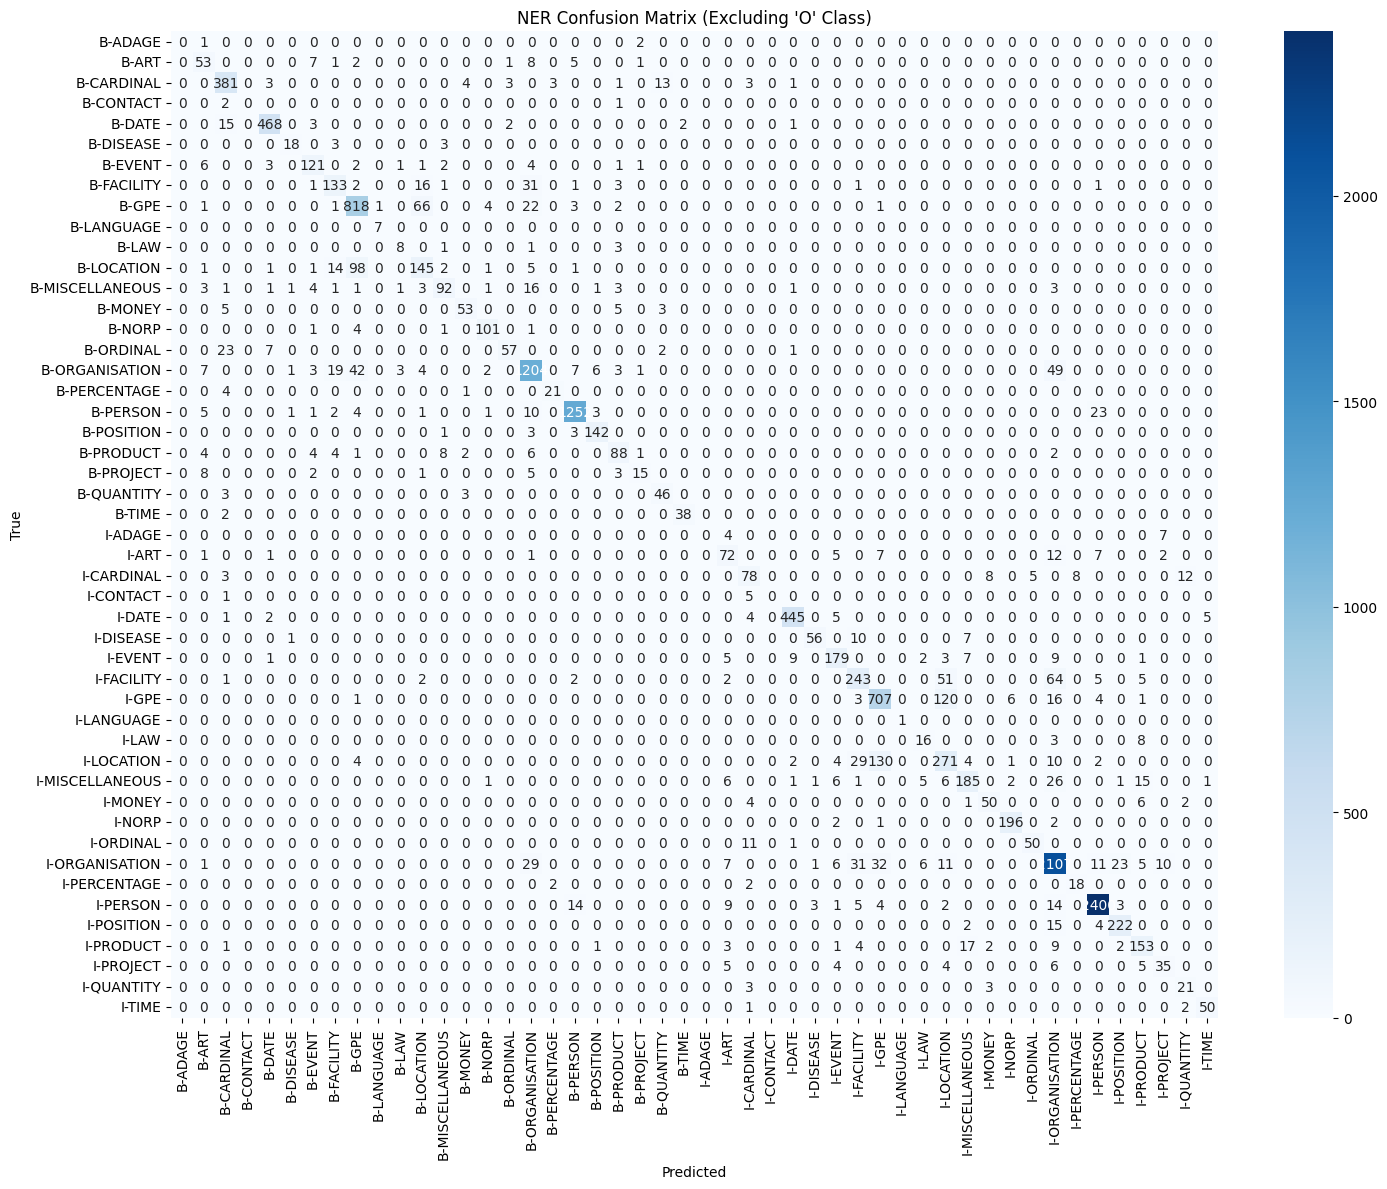

In [58]:
# Create label mapping for consistent ordering
label_order = sorted(unique_labels)

# Generate confusion matrix
cm = confusion_matrix(
    sum(true_labels, []),
    sum(true_predictions, []),
    labels=label_order
)

plt.figure(figsize=(15, 12))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_order,
    yticklabels=label_order
)
plt.title("NER Confusion Matrix (Excluding 'O' Class)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

**We can see that the part of dataset that I have been working with is not equally distributed and this results in greater True Positives of entities that are majorly present in the dataset**

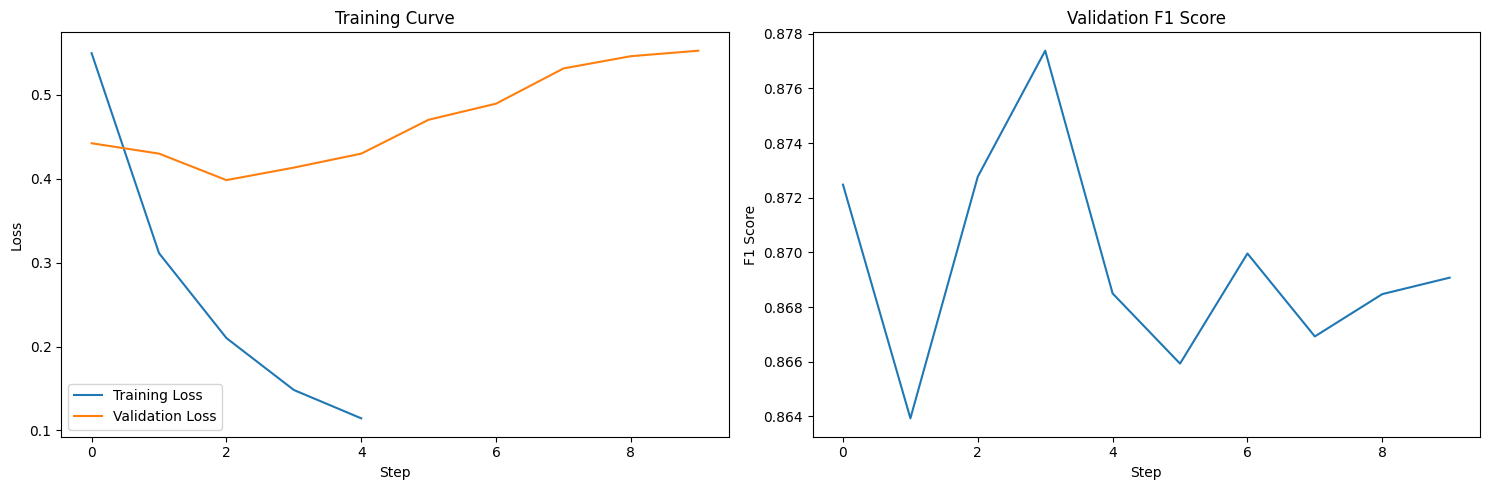

In [59]:
if hasattr(trainer, 'state'):
    history = trainer.state.log_history
    train_loss = [x['loss'] for x in history if 'loss' in x]
    eval_metrics = [x for x in history if 'eval_loss' in x]
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label="Training Loss")
    if eval_metrics:
        plt.plot([x['eval_loss'] for x in eval_metrics], label="Validation Loss")
    plt.title("Training Curve")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    if eval_metrics and 'eval_f1' in eval_metrics[0]:
        plt.plot([x['eval_f1'] for x in eval_metrics])
        plt.title("Validation F1 Score")
        plt.xlabel("Step")
        plt.ylabel("F1 Score")
    
    plt.tight_layout()
    plt.show()

**We can observe that after third epoch of training, training loss rapidly decreases, while validation loss steadily increases. This is a sign of overfitting. In this experiment, due to the time and computational limitations, I used just a small part of the dataset, which is likely a reason behind metrics and overfitting.**